<a href="https://colab.research.google.com/github/snekkerru/hse-gsb-price/blob/main/price_prediction_hse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The task is to predict the cost of apartments on a test dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

pd.options.display.max_columns = None

In [ ]:
train_df = pd.read_csv('drive/MyDrive/hse-gsb-apartment-price-prediction/train.csv', sep=';')
test_df = pd.read_csv('drive/MyDrive/hse-gsb-apartment-price-prediction/test.csv', sep=';')

# EDA

Let's look at the amount of data first

In [ ]:
train_df.info()
# ~ 29000 lines, some columns contain missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29044 entries, 0 to 29043
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           29044 non-null  int64  
 1   Категория                    29044 non-null  object 
 2   Заголовок                    29044 non-null  object 
 3   Опции продажи                28584 non-null  object 
 4   Тип                          29044 non-null  object 
 5   Общая площадь                29044 non-null  float64
 6   Жилая площадь                29044 non-null  float64
 7   Площадь кухни                29044 non-null  float64
 8   Этаж                         29044 non-null  int64  
 9   Кол-во этажей в доме         29044 non-null  int64  
 10  Лифт пассажирский (кол-во)   27948 non-null  float64
 11  Лифт грузовой (кол-во)       27753 non-null  float64
 12  Балкон/лоджия                5822 non-null   object 
 13  Мусоропровод    

In [ ]:
test_df.info()
# ~ 8000 lines, some columns contain missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8263 entries, 0 to 8262
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           8263 non-null   int64  
 1   Категория                    8263 non-null   object 
 2   Заголовок                    8263 non-null   object 
 3   Опции продажи                8119 non-null   object 
 4   Тип                          8263 non-null   object 
 5   Общая площадь                8263 non-null   float64
 6   Жилая площадь                8263 non-null   float64
 7   Площадь кухни                8263 non-null   float64
 8   Этаж                         8263 non-null   int64  
 9   Кол-во этажей в доме         8263 non-null   int64  
 10  Лифт пассажирский (кол-во)   7943 non-null   float64
 11  Лифт грузовой (кол-во)       7857 non-null   float64
 12  Балкон/лоджия                1013 non-null   object 
 13  Мусоропровод      

Percentage of missing data from the total number of records.<br>Data in **Кол-во совмещенных санузлов** completely absent - because we don’t understand why, we can remove this column from the analysis for now, while there are other columns where half of the data is missing: **Ремонт**, **Балкон/лоджия**, **Высота потолков**, **Вид из окон**

In [ ]:
(train_df.isna().sum()[train_df.isna().sum() > 0] / train_df.shape[0]).sort_values(ascending=False)

Кол-во совмещенных санузлов    1.000000
Ремонт                         0.987880
Балкон/лоджия                  0.799546
Высота потолков                0.572373
Вид из окон                    0.518765
Кол-во раздельных санузлов     0.241909
Изображения                    0.119233
Парковка                       0.111486
Количество комнат              0.061699
Расстояние до метро            0.061390
Лифт грузовой (кол-во)         0.044450
Лифт пассажирский (кол-во)     0.037736
Опции продажи                  0.015838
Тип дома                       0.007471
Название дома (ЖК)             0.006989
dtype: float64

In [ ]:
# on the test set the situation is similar
(test_df.isna().sum()[test_df.isna().sum() > 0] / test_df.shape[0]).sort_values(ascending=False)

Кол-во совмещенных санузлов    1.000000
Ремонт                         0.992739
Балкон/лоджия                  0.877405
Вид из окон                    0.551858
Высота потолков                0.508290
Кол-во раздельных санузлов     0.161927
Парковка                       0.123442
Изображения                    0.095607
Количество комнат              0.076486
Лифт грузовой (кол-во)         0.049135
Лифт пассажирский (кол-во)     0.038727
Расстояние до метро            0.025172
Опции продажи                  0.017427
Тип дома                       0.005083
dtype: float64

Let's take a closer look at the content of the data

In [ ]:
train_df.head(2)

,ID,Категория,Заголовок,Опции продажи,Тип,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Кол-во этажей в доме,Лифт пассажирский (кол-во),Лифт грузовой (кол-во),Балкон/лоджия,Мусоропровод,Парковка,Количество комнат,Тип дома,Название дома (ЖК),Высота потолков,Кол-во раздельных санузлов,Кол-во совмещенных санузлов,Ремонт,Вид из окон,Расстояние до метро,Адрес,Описания,Стоимость,Актуальность,Изображения,Регион
0,16592911,Недвижимость в Москве/Продажа/Продажа 2-комнат...,"2-комн. квартира, 70.03 м2",Возможна ипотека,Новостройка,70.03,41.8,13.7,2,17,1.0,1.0,Балкон,Да,подземная,2.0,Монолитный,ЖК «Белая звезда»,NaN,1.0,NaN,NaN,NaN,12 мин. на транспорте,"Москва,НАО (Новомосковский),Щербинка,улица 40 ...",Продается просторная двухкомнатная квартира 70...,7073030,Опубликовано,https://cdn-p.cian.site/images/3/824/736/novos...,Москва
1,17242255,Недвижимость в Москве/Продажа/Продажа 3-комнат...,"3-комн. квартира, 76.47 м2",Возможна ипотека,Новостройка,76.47,43.4,11.2,11,17,1.0,1.0,Балкон,Да,подземная,3.0,Монолитный,ЖК «Белая звезда»,NaN,1.0,NaN,NaN,Во двор,12 мин. на транспорте,"Москва,НАО (Новомосковский),Щербинка,улица 40 ...","Продается трехкомнатная квартира 76,47 кв.м с ...",7799940,Опубликовано,https://cdn-p.cian.site/images2/5/690/176/novo...,Москва


There are categorical features that have up to 10-15 categories.<br>
Also in columns **Описания**, **Адрес**, **Название дома (ЖК)** there are duplicate values for different ad IDs, because their unique number of < unique ID values, there is an assumption that the same ads could be submitted several times or these are the same type of apartments.

In [ ]:
for col in train_df.columns:
  print(col)
  n1 = train_df[col].nunique(dropna=False)
  n2 = test_df[col].nunique(dropna=False) if col in test_df.columns else 0
  print(f'Number of unique values in the train: {n1}, in test: {n2}')
  print()

ID
Number of unique values in the train: 29044, in test: 8263

Категория
Number of unique values in the train: 2837, in test: 910

Заголовок
Number of unique values in the train: 6244, in test: 2292

Опции продажи
Number of unique values in the train: 8, in test: 7

Тип
Number of unique values in the train: 2, in test: 2

Общая площадь
Number of unique values in the train: 4076, in test: 1681

Жилая площадь
Number of unique values in the train: 692, in test: 607

Площадь кухни
Number of unique values in the train: 363, in test: 269

Этаж
Number of unique values in the train: 68, in test: 44

Кол-во этажей в доме
Number of unique values in the train: 63, in test: 44

Лифт пассажирский (кол-во)
Number of unique values in the train: 10, in test: 11

Лифт грузовой (кол-во)
Number of unique values in the train: 8, in test: 11

Балкон/лоджия
Number of unique values in the train: 3, in test: 3

Мусоропровод
Number of unique values in the train: 2, in test: 2

Парковка
Number of unique values 

In text features by type **Категория**, **Заголовок**, **Название дома (ЖК)**, **Адрес**, **Описания** less than 1-3% of repeated values and / or a lot of categories (to work with them, you will need more complex text transformation methods associated with neural networks).<br><br>
Columns **Опции продажи**, **Тип**, **Балкон/лоджия** (about 80% of missing values, there is an assumption that this means that there is no **Балкон** or **Лоджия**), **Мусоропровод**, **Парковка**, **Тип дома**, **Вид из окон** (about half of the values are missing), **Расстояние до метро**, **Регион** - text features with more highlighted categories (many meanings are repeated).<br><br>
Columns **Общая площадь**, **Жилая площадь** (there are apartments with zero area), **Площадь кухни** (there are apartments without a kitchen), **Этаж**, **Кол-во этажей в доме**, **Лифт пассажирский (кол-во)**, **Лифт грузовой (кол-во)**, **Количество комнат**, **Высота потолков** (about half of the values are missing), **Кол-во раздельных санузлов** - can be counted as numbers.<br><br>
Values of **Актуальность** feature is not entirely clear how they can influence the price of an apartment, so we will refuse it at the moment.

In [ ]:
for col in train_df.columns:
  # remove id, url links to images and columns with a large number of missing values
  if col not in ('ID', 'Изображения', 'Кол-во совмещенных санузлов', 'Ремонт'):
    print(col)
    print('TRAIN value counts:')
    display(train_df[col].value_counts(dropna=False, normalize=True))
    print()
    try:
      print('TEST value counts:')
      display(test_df[col].value_counts(dropna=False, normalize=True))
    except:
      print()
    print('*'*100)

Категория
TRAIN value counts:


Недвижимость в Москве/Продажа/Продажа 1-комнатных квартир в Москве/СЗАО/Хорошево-Мневники/метро Панфиловская/3-я Хорошевская улица                                                                0.018317
Недвижимость в Москве/Продажа/Продажа 3-комнатных квартир в Москве/Киевское шоссе/НАО (Новомосковский)/Московский/метро Румянцево                                                                 0.015528
Недвижимость в Москве/Продажа/Продажа 1-комнатных квартир в Москве/СВАО/Алексеевский/метро Алексеевская/Новоалексеевская улица                                                                    0.014736
Недвижимость в Москве/Продажа/Продажа 2-комнатных квартир в Москве/пос. Коммунарка/Калужское шоссе/НАО (Новомосковский)/Сосенское/метро Коммунарка                                                0.007540
Недвижимость в Москве/Продажа/Продажа 1-комнатных квартир в Москве/СЗАО/Хорошево-Мневники/метро Хорошево                                                                                    


TEST value counts:


Недвижимость в Москве/Продажа/Продажа 2-комнатных квартир в Москве/ЮВАО/Рязанский/метро Стахановская                                                                         0.032434
Недвижимость в Москве/Продажа/Продажа 2-комнатных квартир в Москве/ВАО/Богородское/метро Преображенская площадь/Краснобогатырская улица                                      0.019848
Недвижимость в Москве/Продажа/Продажа 1-комнатных квартир в Москве/ЮВАО/Рязанский/метро Стахановская                                                                         0.018153
Недвижимость в Москве/Продажа/Продажа 2-комнатных квартир в Москве/пос. Коммунарка/Бунинские Луга ЖК/Калужское шоссе/НАО (Новомосковский)/Сосенское/метро Бунинская аллея    0.016096
Недвижимость в Москве/Продажа/Продажа 1-комнатных квартир в Москве/ЮАО/Даниловский/метро Технопарк/проспект Андропова                                                        0.015612
                                                                                          

****************************************************************************************************
Заголовок
TRAIN value counts:


1-комн. квартира, 46.8 м2     0.004407
1-комн. квартира, 39.0 м2     0.003787
1-комн. квартира, 46.6 м2     0.003753
1-комн. квартира, 47.3 м2     0.003443
2-комн. квартира, 57.4 м2     0.003271
                                ...   
3-комн. квартира, 75.45 м2    0.000034
студия, 62.12 м2              0.000034
2-комн. квартира, 76.35 м2    0.000034
2-комн. квартира, 78.61 м2    0.000034
3-комн. квартира, 136.6 м2    0.000034
Name: Заголовок, Length: 6244, dtype: float64


TEST value counts:


2-комн. квартира, 61.5 м2        0.009803
2-комн. квартира, 56.0 м2        0.008835
1-комн. квартира, 38.0 м2        0.006898
1-комн. апартаменты, 25.85 м2    0.006414
2-комн. квартира, 63.3 м2        0.005809
                                   ...   
2-комн. квартира, 53.1 м2        0.000121
1-комн. апартаменты, 37.5 м2     0.000121
1-комн. апартаменты, 18.83 м2    0.000121
1-комн. апартаменты, 18.67 м2    0.000121
2-комн. квартира, 36.6 м2        0.000121
Name: Заголовок, Length: 2292, dtype: float64

****************************************************************************************************
Опции продажи
TRAIN value counts:


Долевое участие (214-ФЗ), Возможна ипотека    0.764633
Возможна ипотека                              0.110350
Свободная продажа, Возможна ипотека           0.097886
NaN                                           0.015838
Долевое участие (214-ФЗ)                      0.007575
Свободная продажа                             0.002238
Альтернатива, Возможна ипотека                0.001343
Альтернатива                                  0.000138
Name: Опции продажи, dtype: float64


TEST value counts:


Долевое участие (214-ФЗ), Возможна ипотека    0.801767
Возможна ипотека                              0.102505
Свободная продажа, Возможна ипотека           0.063294
NaN                                           0.017427
Долевое участие (214-ФЗ)                      0.012465
Свободная продажа                             0.002420
Альтернатива, Возможна ипотека                0.000121
Name: Опции продажи, dtype: float64

****************************************************************************************************
Тип
TRAIN value counts:


Новостройка    0.986607
Вторичка       0.013393
Name: Тип, dtype: float64


TEST value counts:


Новостройка    0.991529
Вторичка       0.008471
Name: Тип, dtype: float64

****************************************************************************************************
Общая площадь
TRAIN value counts:


46.80     0.004648
39.00     0.004201
46.60     0.003891
47.30     0.003787
57.40     0.003477
            ...   
65.15     0.000034
21.27     0.000034
23.03     0.000034
21.98     0.000034
136.60    0.000034
Name: Общая площадь, Length: 4076, dtype: float64


TEST value counts:


56.00     0.010045
61.50     0.009924
38.00     0.007382
25.85     0.006414
69.00     0.006051
            ...   
131.70    0.000121
33.65     0.000121
220.00    0.000121
34.80     0.000121
66.37     0.000121
Name: Общая площадь, Length: 1681, dtype: float64

****************************************************************************************************
Жилая площадь
TRAIN value counts:


0.0     0.175355
14.3    0.007575
14.2    0.007265
15.1    0.006507
14.1    0.006439
          ...   
64.9    0.000034
89.4    0.000034
91.0    0.000034
68.6    0.000034
72.5    0.000034
Name: Жилая площадь, Length: 692, dtype: float64


TEST value counts:


0.0     0.134697
30.0    0.012102
25.5    0.010771
13.3    0.010408
27.0    0.009319
          ...   
68.8    0.000121
51.6    0.000121
56.5    0.000121
69.1    0.000121
56.3    0.000121
Name: Жилая площадь, Length: 607, dtype: float64

****************************************************************************************************
Площадь кухни
TRAIN value counts:


0.0     0.211782
10.0    0.017560
11.0    0.014702
10.5    0.011087
12.0    0.010673
          ...   
32.5    0.000034
43.8    0.000034
37.2    0.000034
51.0    0.000034
2.2     0.000034
Name: Площадь кухни, Length: 363, dtype: float64


TEST value counts:


0.0     0.197870
10.0    0.020211
15.0    0.018395
13.0    0.015370
14.2    0.014886
          ...   
31.6    0.000121
32.1    0.000121
30.8    0.000121
31.3    0.000121
1.3     0.000121
Name: Площадь кухни, Length: 269, dtype: float64

****************************************************************************************************
Этаж
TRAIN value counts:


2     0.101914
3     0.071478
4     0.058876
6     0.053264
5     0.052128
        ...   
57    0.000034
61    0.000034
62    0.000034
69    0.000034
63    0.000034
Name: Этаж, Length: 68, dtype: float64


TEST value counts:


2     0.111824
3     0.067409
4     0.057122
5     0.053612
7     0.050103
6     0.048046
8     0.046956
9     0.043447
1     0.040421
14    0.040421
13    0.037880
10    0.037033
11    0.035822
15    0.035701
12    0.035338
16    0.034128
17    0.026504
18    0.025657
19    0.022389
23    0.021542
20    0.019000
21    0.018032
24    0.017185
22    0.015733
25    0.011376
30    0.005930
27    0.005809
28    0.005446
33    0.004599
29    0.004478
32    0.004115
31    0.003994
26    0.003873
34    0.001936
35    0.001452
37    0.001210
39    0.000968
43    0.000968
44    0.000726
38    0.000605
36    0.000605
41    0.000242
40    0.000242
42    0.000121
Name: Этаж, dtype: float64

****************************************************************************************************
Кол-во этажей в доме
TRAIN value counts:


22    0.103636
25    0.092549
17    0.091034
16    0.065797
23    0.048306
        ...   
75    0.000034
65    0.000034
68    0.000034
35    0.000034
85    0.000034
Name: Кол-во этажей в доме, Length: 63, dtype: float64


TEST value counts:


25    0.122111
17    0.109766
9     0.072371
23    0.060269
16    0.054218
14    0.049256
19    0.043689
24    0.041389
20    0.038364
15    0.036912
33    0.035943
8     0.030497
18    0.029892
22    0.027593
5     0.026504
12    0.021663
32    0.021179
7     0.019726
21    0.019484
28    0.017306
4     0.016338
39    0.013675
35    0.011981
11    0.011739
34    0.010287
27    0.008835
13    0.008350
6     0.007019
10    0.005930
30    0.005930
44    0.004841
31    0.003873
45    0.002905
38    0.002541
29    0.001936
26    0.001815
36    0.001089
3     0.001089
37    0.000847
2     0.000363
42    0.000121
50    0.000121
41    0.000121
40    0.000121
Name: Кол-во этажей в доме, dtype: float64

****************************************************************************************************
Лифт пассажирский (кол-во)
TRAIN value counts:


1.0     0.751722
2.0     0.165060
NaN     0.037736
0.0     0.023826
3.0     0.016596
4.0     0.002272
8.0     0.001687
6.0     0.001033
5.0     0.000034
15.0    0.000034
Name: Лифт пассажирский (кол-во), dtype: float64


TEST value counts:


1.0     0.760620
2.0     0.136512
NaN     0.038727
0.0     0.034612
6.0     0.016943
4.0     0.005204
3.0     0.004478
9.0     0.001331
5.0     0.000847
12.0    0.000605
10.0    0.000121
Name: Лифт пассажирский (кол-во), dtype: float64

****************************************************************************************************
Лифт грузовой (кол-во)
TRAIN value counts:


1.0     0.482544
0.0     0.306397
2.0     0.155523
NaN     0.044450
3.0     0.005750
4.0     0.003753
8.0     0.001549
15.0    0.000034
Name: Лифт грузовой (кол-во), dtype: float64


TEST value counts:


1.0     0.511194
0.0     0.288273
2.0     0.137480
NaN     0.049135
4.0     0.006172
3.0     0.003147
11.0    0.001694
9.0     0.001331
5.0     0.000847
12.0    0.000605
10.0    0.000121
Name: Лифт грузовой (кол-во), dtype: float64

****************************************************************************************************
Балкон/лоджия
TRAIN value counts:


NaN       0.799546
Балкон    0.196805
Лоджия    0.003650
Name: Балкон/лоджия, dtype: float64


TEST value counts:


NaN       0.877405
Балкон    0.109524
Лоджия    0.013070
Name: Балкон/лоджия, dtype: float64

****************************************************************************************************
Мусоропровод
TRAIN value counts:


Нет    0.994491
Да     0.005509
Name: Мусоропровод, dtype: float64


TEST value counts:


Нет    0.996369
Да     0.003631
Name: Мусоропровод, dtype: float64

****************************************************************************************************
Парковка
TRAIN value counts:


подземная     0.427868
Неизвестно    0.398843
NaN           0.111486
Наземная      0.061803
Name: Парковка, dtype: float64


TEST value counts:


Неизвестно    0.430957
подземная     0.390415
NaN           0.123442
Наземная      0.055186
Name: Парковка, dtype: float64

****************************************************************************************************
Количество комнат
TRAIN value counts:


2.0    0.393851
1.0    0.287908
3.0    0.230375
NaN    0.061699
4.0    0.024687
5.0    0.001102
6.0    0.000379
Name: Количество комнат, dtype: float64


TEST value counts:


2.0    0.414498
1.0    0.277139
3.0    0.203800
NaN    0.076486
4.0    0.024446
5.0    0.003389
6.0    0.000242
Name: Количество комнат, dtype: float64

****************************************************************************************************
Тип дома
TRAIN value counts:


Монолитный             0.887894
Панельный              0.080671
Кирпичный              0.015735
Монолитно-кирпичный    0.008160
NaN                    0.007471
Сталинский             0.000069
Name: Тип дома, dtype: float64


TEST value counts:


Монолитный             0.795232
Панельный              0.169309
Кирпичный              0.020695
Монолитно-кирпичный    0.009682
NaN                    0.005083
Name: Тип дома, dtype: float64

****************************************************************************************************
Название дома (ЖК)
TRAIN value counts:


ЖК «Хорошевский»          0.039871
ЖК «Скандинавия»          0.027751
ЖК «Серебряный фонтан»    0.024170
ЖК «Румянцево-Парк»       0.024101
ЖК «Саларьево парк»       0.015631
                            ...   
ЖК «Чемпион парк»         0.000034
ЖК «Новый бульвар»        0.000034
ЖК «Водный»               0.000034
ЖК «Восточный 7»          0.000034
ЖК «Эдельвейс-Комфорт»    0.000034
Name: Название дома (ЖК), Length: 581, dtype: float64


TEST value counts:


ЖК «Кварталы 21/19»        0.065231
ЖК «Бунинские луга»        0.050587
ЖК «Испанские кварталы»    0.043689
ЖК «Шереметьевский»        0.040784
ЖК «Level Амурская»        0.037154
                             ...   
ЖК «Пеликан»               0.000121
ЖК «Тихвинская усадьба»    0.000121
ЖК «Пятница-Молодежный»    0.000121
ЖК «Ольгино, корп. 13»     0.000121
ЖК «Маяковского»           0.000121
Name: Название дома (ЖК), Length: 196, dtype: float64

****************************************************************************************************
Высота потолков
TRAIN value counts:


NaN       0.572373
3.000     0.085250
2.700     0.053953
2.650     0.043761
2.800     0.042177
3.100     0.029438
3.250     0.023998
2.890     0.021381
2.900     0.016940
2.750     0.010157
3.500     0.010088
0.000     0.008849
2.720     0.008470
2.850     0.007816
2.840     0.007471
2.000     0.007299
2.660     0.007058
2.630     0.006370
2.950     0.005819
3.200     0.005233
2.640     0.004510
3.190     0.004304
2.820     0.002651
2.740     0.002617
4.200     0.002204
3.130     0.002031
3.050     0.001481
3.150     0.001308
3.230     0.000998
3.300     0.000930
3.120     0.000930
2.780     0.000275
2.860     0.000275
3.080     0.000241
3.580     0.000172
3.600     0.000138
4.000     0.000103
3.800     0.000103
2.500     0.000103
6.000     0.000069
3.070     0.000069
2.600     0.000069
2.990     0.000034
3.180     0.000034
6.100     0.000034
2.870     0.000034
3.700     0.000034
4.620     0.000034
2.400     0.000034
3.950     0.000034
5.800     0.000034
99.999    0.000034
5.000     0.


TEST value counts:


NaN       0.508290
2.65      0.094760
2.85      0.049982
3.11      0.045867
2.72      0.039816
2.80      0.036427
3.00      0.035822
2.95      0.035822
2.68      0.024446
3.10      0.018153
3.20      0.018153
2.77      0.015370
2.78      0.014765
2.66      0.013554
2.75      0.011013
4.00      0.010166
2.93      0.008108
2.70      0.005446
0.00      0.005204
3.15      0.001694
3.30      0.001331
3.50      0.001331
3.13      0.001210
2.90      0.000484
3.08      0.000363
3.05      0.000363
3.25      0.000363
5.00      0.000242
2.60      0.000242
3.28      0.000121
2.74      0.000121
4.80      0.000121
2.00      0.000121
320.00    0.000121
3.80      0.000121
4.05      0.000121
2.76      0.000121
3.35      0.000121
3.23      0.000121
Name: Высота потолков, dtype: float64

****************************************************************************************************
Кол-во раздельных санузлов
TRAIN value counts:


0.0    0.351019
1.0    0.295448
NaN    0.241909
2.0    0.110074
3.0    0.001549
Name: Кол-во раздельных санузлов, dtype: float64


TEST value counts:


0.0    0.373956
1.0    0.338134
NaN    0.161927
2.0    0.124289
3.0    0.001573
4.0    0.000121
Name: Кол-во раздельных санузлов, dtype: float64

****************************************************************************************************
Вид из окон
TRAIN value counts:


NaN                0.518765
Во двор            0.223936
На улицу           0.145917
На улицу и двор    0.111383
Name: Вид из окон, dtype: float64


TEST value counts:


NaN                0.551858
Во двор            0.232240
На улицу           0.112308
На улицу и двор    0.103594
Name: Вид из окон, dtype: float64

****************************************************************************************************
Расстояние до метро
TRAIN value counts:


2 мин. на транспорте     0.154972
3 мин. на транспорте     0.099435
5 мин. на транспорте     0.063042
NaN                      0.061390
6 мин. на транспорте     0.052885
                           ...   
47 мин. пешком           0.000034
48 мин. на транспорте    0.000034
56 мин. пешком           0.000034
53 мин. на транспорте    0.000034
56 мин. на транспорте    0.000034
Name: Расстояние до метро, Length: 127, dtype: float64


TEST value counts:


3 мин. на транспорте     0.141353
2 мин. на транспорте     0.136875
5 мин. на транспорте     0.069224
8 мин. пешком            0.065957
6 мин. на транспорте     0.053491
                           ...   
34 мин. на транспорте    0.000121
73 мин. пешком           0.000121
87 мин. на транспорте    0.000121
29 мин. пешком           0.000121
60 мин. на транспорте    0.000121
Name: Расстояние до метро, Length: 87, dtype: float64

****************************************************************************************************
Адрес
TRAIN value counts:


Москва,НАО (Новомосковский),Родниковая улица                                        0.024205
Москва,СВАО,район Алексеевский,Новоалексеевская улица,16                            0.016320
Москва,САО,район Ховрино,улица Дыбенко                                              0.013669
Москва,СЗАО,район Хорошево-Мневники,3-я Хорошевская улица,7к2                       0.013428
Москва,ЮАО,район Москворечье-Сабурово,Каширский проезд,25к1                         0.011672
                                                                                      ...   
Московская область,Воскресенск,Лопатинский мкр,улица Комсомольская,17               0.000034
Москва,СЗАО,район Хорошево-Мневники,Сердце Столицы ЖК,к7                            0.000034
Московская область,Наро-Фоминский городской округ,Апрелевка,улица Островского,36    0.000034
Московская область,Щелково городской округ,д. Медвежьи Озера                        0.000034
Московская область,Истра городской округ,д. Лобаново,4                


TEST value counts:


Москва,ЮВАО,район Рязанский,2-й Грайвороновский проезд                                    0.054097
Москва,НАО (Новомосковский),Сосенское поселение,улица Николо-Хованская                    0.036185
Москва,СВАО,район Лосиноостровский,Янтарный проезд                                        0.031345
Москва,ВАО,район Богородское,Краснобогатырская улица,38                                   0.027835
Москва,ЮЗАО,район Черемушки,Нахимовский проспект                                          0.023357
                                                                                            ...   
Московская область,Красногорск городской округ,пос. Ильинское-Усово,улица Заповедная,1    0.000121
Москва,НАО (Новомосковский),Московский поселение,Татьянин Парк мкр,к8А                    0.000121
Москва,ЦАО,район Пресненский,улица Пресненский Вал,21                                     0.000121
Москва,ЦАО,район Басманный,Нижняя Красносельская улица,35С48                              0.000121
Московская

****************************************************************************************************
Описания
TRAIN value counts:


О жилом комплексе. Новый проект бизнес-класса на северо-западе Москвы- городской квартал Big Time. Три жилых дома высотой 21 этаж на Звенигородском шоссе. 10 минут пешком до метро "Хорошево", 5 минут до Москва-Сити. Подземный паркинг, кладовые, двор без машин. Собственная инфраструктура!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


TEST value counts:


В продаже АПАРТАМЕНТЫ в новом МФК бизнес-класса на Нахимовском проспекте. Монолитный комплекс строится по индивидуальному проекту: фасад с отделкой из натуральных материалов, просторные холлы входных групп и продуманный формат апартаментов (высокие потолки (3 м) и свободные планировки). Комплекс отличает удобная транспортная доступность: 10-15 минут пешком до станции метро Профсоюзная или выезд на автомобиле на две крупные магистрали - Севастопольский и Нахимовский проспекты. В непосредственной близости находится обширная парковая зона с каскадом прудов: Криворожским, Верхним и Нижним Коробковским. Комплекс будет оборудован подземным паркингом на 288 машиномест. На первых этажах разместятся коммерческие объекты: кафе, рестораны, развлекательные центры и магазины. Инфраструктура района полностью развита: в пешей доступности находятся четыре школы и пять детских садов. В непосредственной близости - ряд супермаркетов, торговый центр "Нахимовский" и спортивно-досуговый центр "Юго-Запад", б

****************************************************************************************************
Стоимость
TRAIN value counts:


7500000    0.001481
4500000    0.001481
4200000    0.001102
3200000    0.001067
5500000    0.001067
             ...   
8504282    0.000034
9090047    0.000034
7325827    0.000034
9791299    0.000034
5102860    0.000034
Name: Стоимость, Length: 23431, dtype: float64


TEST value counts:

****************************************************************************************************
Актуальность
TRAIN value counts:


Опубликовано          0.883384
Неизвестно            0.109110
Cнято с публикации    0.007506
Name: Актуальность, dtype: float64


TEST value counts:


Опубликовано          0.908145
Неизвестно            0.086288
Cнято с публикации    0.005567
Name: Актуальность, dtype: float64

****************************************************************************************************
Регион
TRAIN value counts:


Москва                0.704517
Люберецкий            0.037323
Одинцовский           0.035154
Мытищи                0.034327
Балашихинский         0.033088
Ленинский             0.026718
Химки                 0.022552
Красногорск           0.019006
Красногорский         0.014117
Пушкинский            0.011534
Истра                 0.008470
Солнечногорск         0.005922
Раменский             0.005647
Королев               0.003994
Богородский           0.003650
Реутов                0.002995
Дмитровский           0.002789
Электросталь          0.002686
Котельники            0.002548
Лыткарино             0.002238
Домодедовский         0.001997
Дзержинский           0.001963
Лобня                 0.001446
Лосино-Петровский     0.001412
Наро-Фоминский        0.001308
Щелковский            0.001239
Ивантеевка            0.001239
Жуковский             0.001136
Подольск              0.001067
Сергиево-Посадский    0.001033
Люберцы               0.000998
Домодедово            0.000826
Пущино  


TEST value counts:


Москва                0.752511
Люберецкий            0.056275
Ленинский             0.038364
Одинцовский           0.029166
Красногорск           0.025899
Химки                 0.019848
Красногорский         0.018879
Наро-Фоминский        0.018032
Люберцы               0.012707
Королев               0.005567
Мытищи                0.004962
Ивантеевка            0.002178
Щелковский            0.001815
Раменский             0.001694
Балашихинский         0.001573
Богородский           0.001452
Реутов                0.001452
Воскресенский         0.001331
Домодедовский         0.000968
Солнечногорск         0.000968
Красноармейск         0.000847
Дмитровский           0.000847
Пушкинский            0.000726
Истра                 0.000363
Долгопрудный          0.000363
Подольск              0.000242
Краснознаменск        0.000242
Орехово-Зуево         0.000121
Фрязино               0.000121
Дубна                 0.000121
Талдомский            0.000121
Сергиево-Посадский    0.000121
Чехов   

****************************************************************************************************


Add some new features

In [ ]:
train_df['Есть кухня'] = (train_df['Площадь кухни'] > 0).map({True: 'Да', False: 'Нет'})
test_df['Есть кухня'] = (test_df['Площадь кухни'] > 0).map({True: 'Да', False: 'Нет'})

train_df['Есть жилая площадь'] = (train_df['Жилая площадь'] > 0).map({True: 'Да', False: 'Нет'})
test_df['Есть жилая площадь'] = (test_df['Жилая площадь'] > 0).map({True: 'Да', False: 'Нет'})

Let's group the columns by their type: categorical, text and numeric

In [ ]:
cat_columns = ['Опции продажи', 'Тип', 'Балкон/лоджия', 'Мусоропровод',
               'Парковка', 'Тип дома', 'Вид из окон', 'Расстояние до метро', 'Регион',
               'Есть кухня', 'Есть жилая площадь']

text_columns = ['Категория', 'Заголовок', 'Название дома (ЖК)', 'Адрес', 'Описания']

num_columns = ['Общая площадь', 'Жилая площадь', 'Площадь кухни', 'Этаж',
               'Кол-во этажей в доме', 'Лифт пассажирский (кол-во)',
               'Лифт грузовой (кол-во)', 'Количество комнат',
               'Высота потолков', 'Кол-во раздельных санузлов', 'Стоимость']

## Analysis of categorical features





Visualize the sizes of each feature category. It can be said that most apartments are new buildings in Moscow, a monolithic house, they require a mortgage, they can have a balcony (with a small loggia) and underground parking (with a small surface), do not have a garbage chute, come with a kitchen and living space.<br>On the test set, the situation is similar.

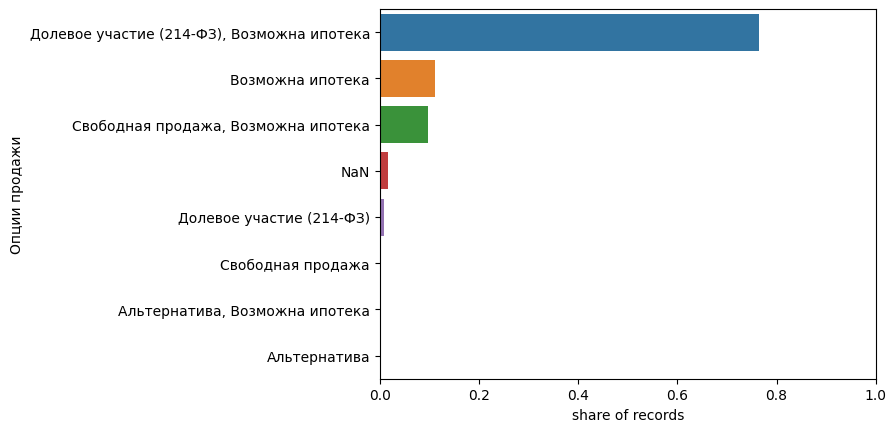

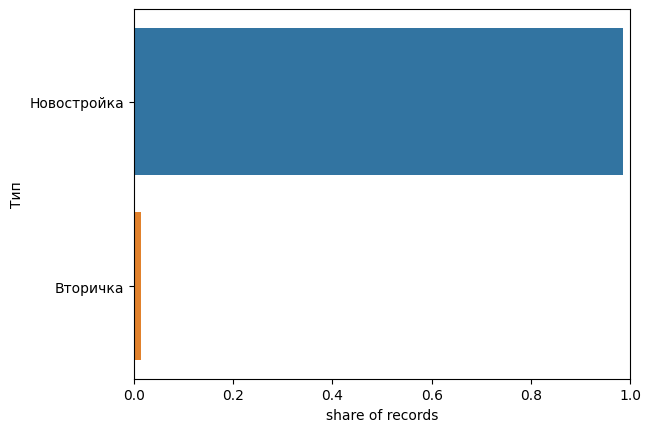

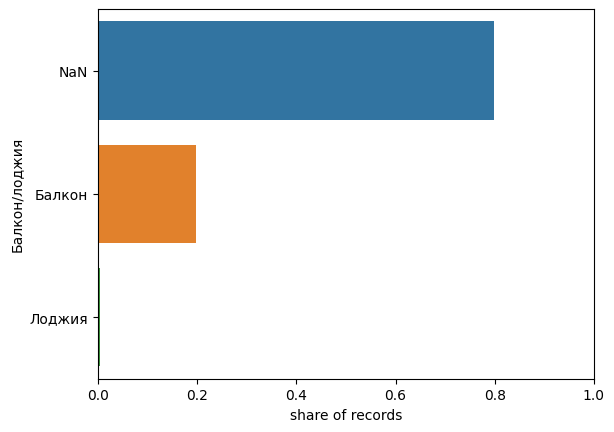

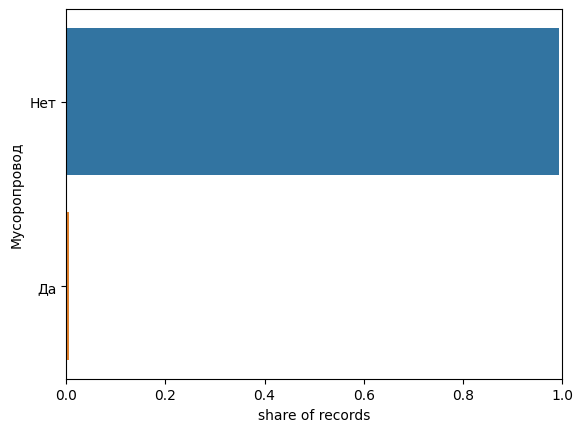

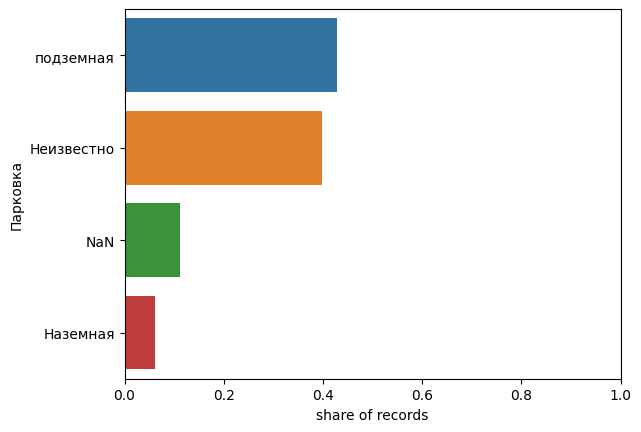

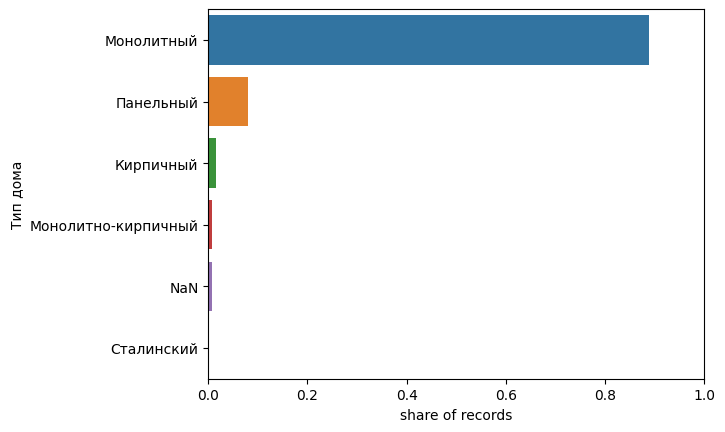

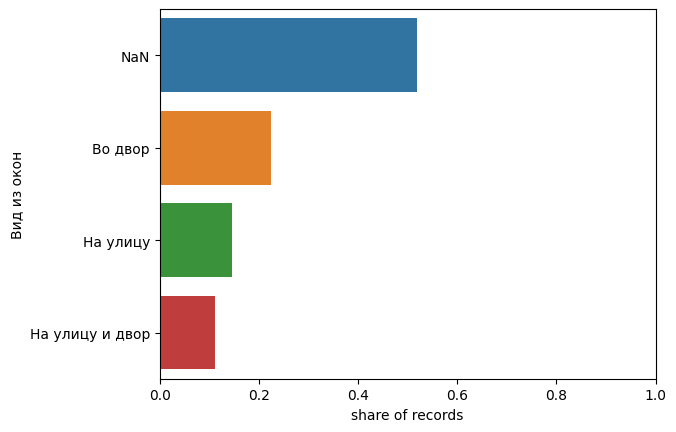

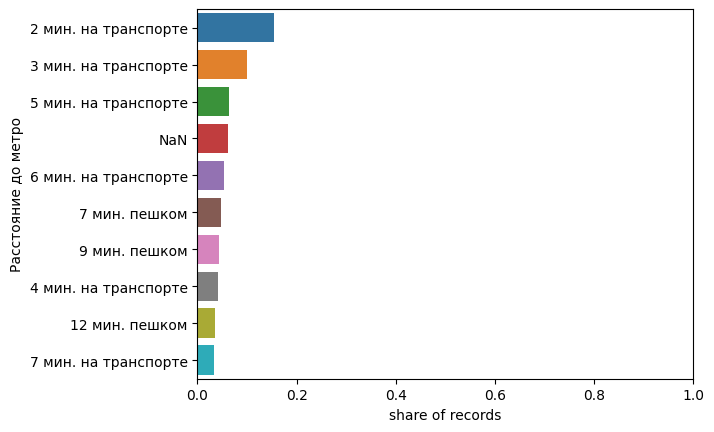

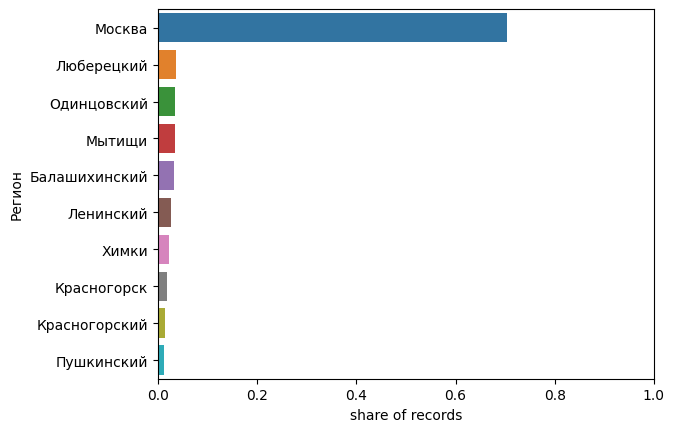

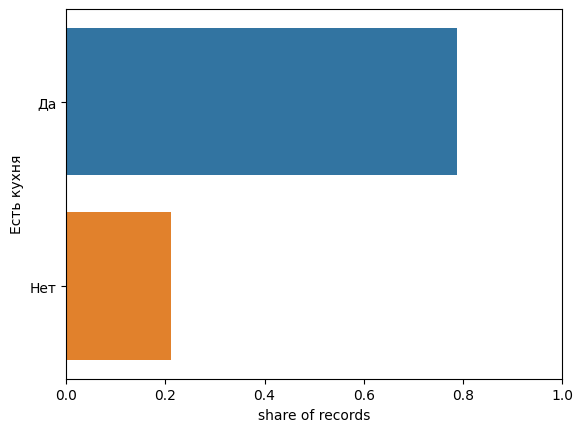

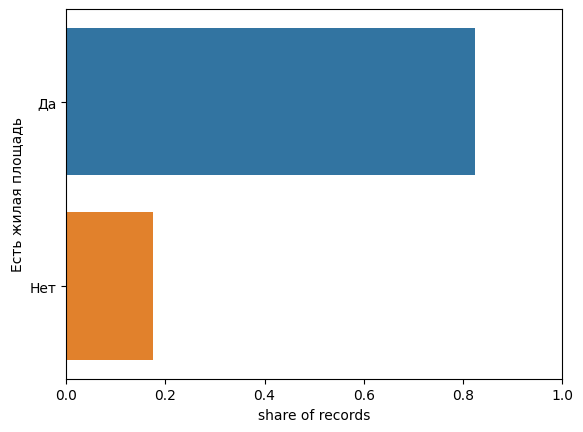

In [ ]:
for col in cat_columns:
  tmp = train_df[col].value_counts(normalize=True, dropna=False).reset_index()
  # Uncomment the line below if you want to get graphics for the test set
  # tmp = test_df[col].value_counts(normalize=True, dropna=False).reset_index()
  tmp.columns = [col, 'share of records']
  # For easy perception, consider the top 10 categories
  tmp = tmp.iloc[:10, :].fillna('NaN')
  ax = sns.barplot(data=tmp, x='share of records', y=col)
  ax.set_xlim(0,1)
  plt.show()

Let's look at the dependence of the target variable (Стоимость) and categorical features using boxplot. Some insights:<br>
- In new buildings, the median price is higher than in the secondary market
- Apartments with a balcony have a price higher than with a Loggia, but lower than with NaN (missing value - maybe that means there are **'Балкон + Лоджия'**?)
- With underground parking apartments are more expensive
- Monolithic houses have a higher median price
- With a view of the window to the street and the courtyard, the price is higher
- The less minutes to the metro, the higher the price
- In Moscow, prices are more expensive than in other regions
- Apartments with a kitchen or living space, on the contrary, have a lower price (perhaps due to an imbalance in the data, such a conclusion)

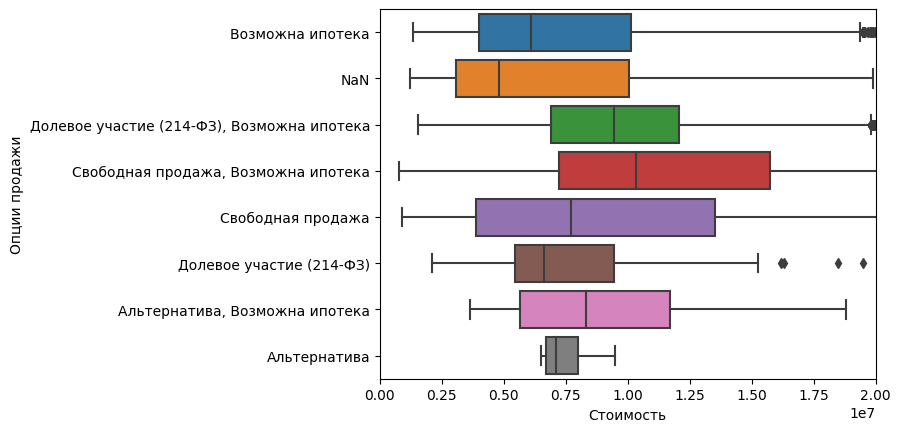

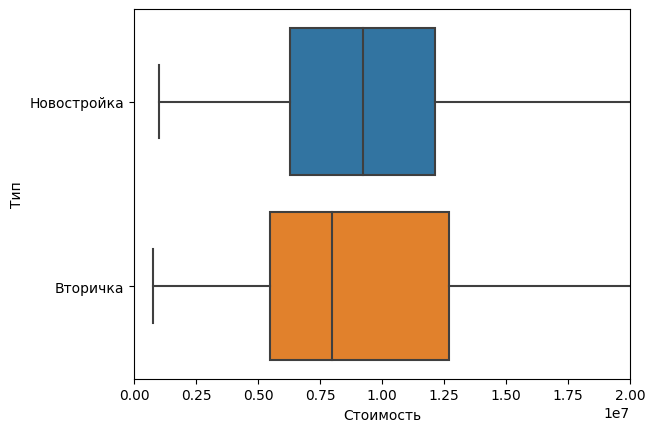

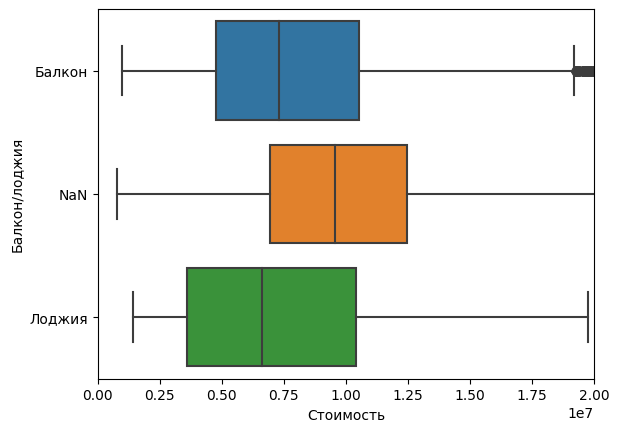

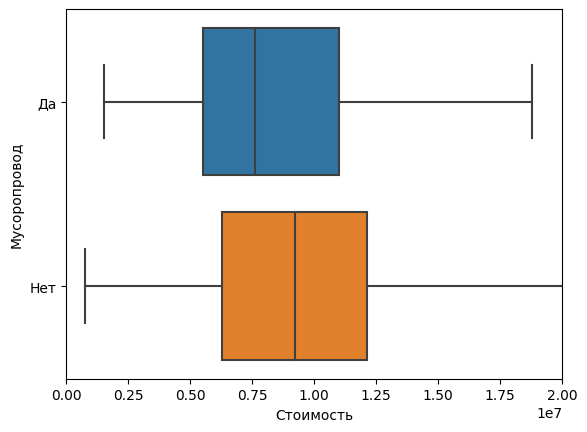

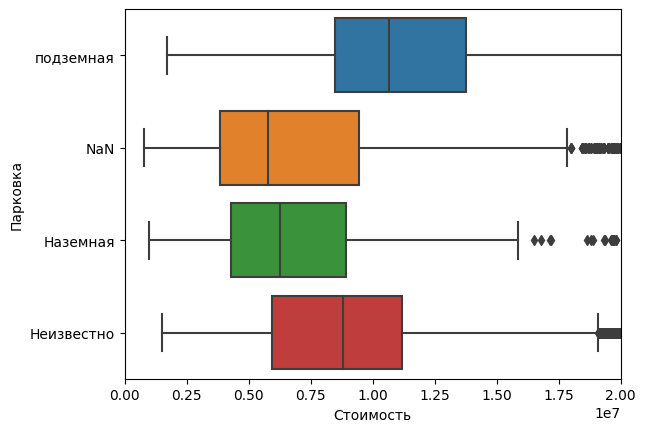

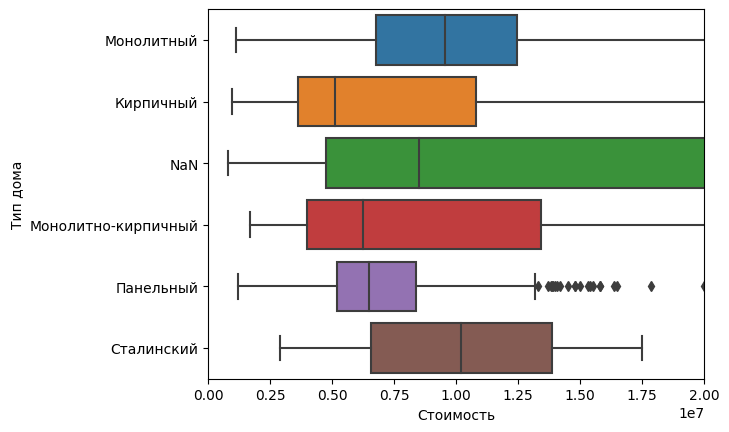

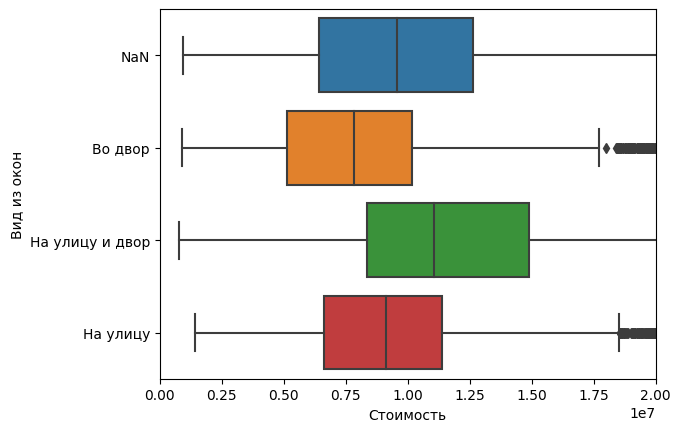

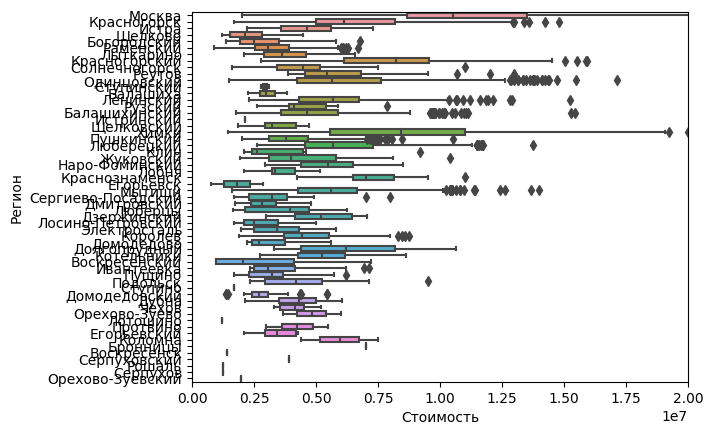

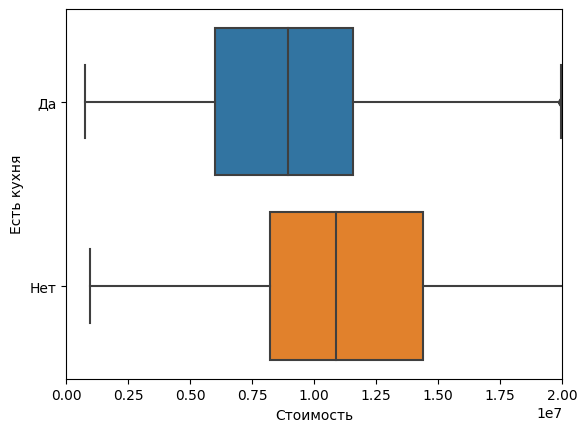

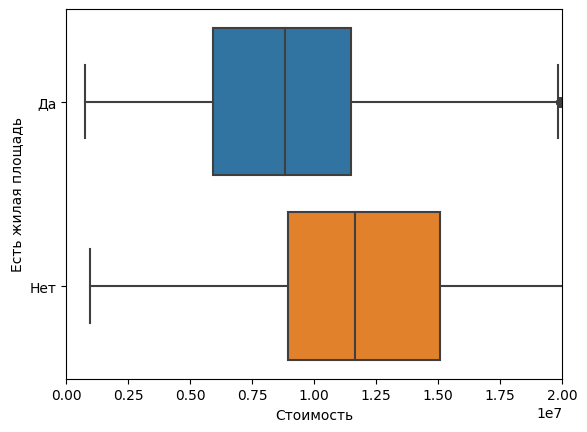

In [ ]:
for col in cat_columns:
  if col != 'Расстояние до метро':
    ax = sns.boxplot(data=train_df.fillna('NaN'), y=col, x='Стоимость')
    # For easy perception, consider the cost up to 20 million
    ax.set_xlim(0, 20_000_000)
    plt.show()

The same statistics in the format of table

In [ ]:
for col in cat_columns:
  print(col)
  display(train_df.groupby([col], dropna=False)['Стоимость'].describe().sort_values('count', ascending=False))
  print()

Опции продажи


,count,mean,std,min,25%,50%,75%,max
Опции продажи,,,,,,,,
"Долевое участие (214-ФЗ), Возможна ипотека",22208.0,1.029842e+07,5.568718e+06,1524000.0,6890072.5,9424310.0,12055134.0,305160000.0
Возможна ипотека,3205.0,8.289125e+06,6.297414e+06,1350000.0,4000000.0,6100000.0,10142629.0,37800000.0
"Свободная продажа, Возможна ипотека",2843.0,1.222957e+07,7.218660e+06,780000.0,7246808.0,10317150.0,15743962.0,52950000.0
NaN,460.0,8.310504e+06,8.442472e+06,1200000.0,3082777.5,4825000.0,10037500.0,59990145.0
Долевое участие (214-ФЗ),220.0,9.706649e+06,7.247977e+06,2100000.0,5433740.5,6608365.5,9462766.5,38740680.0
Свободная продажа,65.0,1.290418e+07,1.999539e+07,900000.0,3900000.0,7700000.0,13500000.0,140000000.0
"Альтернатива, Возможна ипотека",39.0,9.336385e+06,4.688111e+06,3650000.0,5650000.0,8300000.0,11720000.0,21000000.0
Альтернатива,4.0,7.562500e+06,1.359764e+06,6500000.0,6687500.0,7125000.0,8000000.0,9500000.0



Тип


,count,mean,std,min,25%,50%,75%,max
Тип,,,,,,,,
Новостройка,28655.0,1.022512e+07,5.949463e+06,990000.0,6286990.0,9230050.0,12122286.5,305160000.0
Вторичка,389.0,1.088277e+07,1.087362e+07,780000.0,5500000.0,7990000.0,12700000.0,140000000.0



Балкон/лоджия


,count,mean,std,min,25%,50%,75%,max
Балкон/лоджия,,,,,,,,
NaN,23222.0,1.065061e+07,5.797566e+06,780000.0,6943298.25,9563283.0,12472647.75,140000000.0
Балкон,5716.0,8.572953e+06,6.663170e+06,990000.0,4777423.75,7302700.0,10544838.50,305160000.0
Лоджия,106.0,8.515443e+06,7.517910e+06,1400000.0,3587500.00,6600000.0,10400000.00,52950000.0



Мусоропровод


,count,mean,std,min,25%,50%,75%,max
Мусоропровод,,,,,,,,
Нет,28884.0,1.023713e+07,6.035845e+06,780000.0,6282392.0,9223896.5,12129472.5,305160000.0
Да,160.0,9.654995e+06,7.083895e+06,1530000.0,5500000.0,7600000.0,11000000.0,52950000.0



Парковка


,count,mean,std,min,25%,50%,75%,max
Парковка,,,,,,,,
подземная,12427.0,1.205567e+07,5.864545e+06,1700000.0,8474600.0,10655270.0,13759056.0,52950000.0
Неизвестно,11584.0,9.289423e+06,5.468858e+06,1524000.0,5933565.0,8805381.5,11199922.5,305160000.0
NaN,3238.0,8.050401e+06,6.899683e+06,780000.0,3850000.0,5778888.5,9469500.0,140000000.0
Наземная,1795.0,7.655993e+06,5.458055e+06,990000.0,4296035.5,6282428.0,8934808.0,42800000.0



Тип дома


,count,mean,std,min,25%,50%,75%,max
Тип дома,,,,,,,,
Монолитный,25788.0,1.054907e+07,5.993261e+06,1100000.0,6766609.0,9548486.0,12429410.0,305160000.0
Панельный,2343.0,6.838685e+06,2.375334e+06,1200000.0,5175405.0,6463440.0,8381690.0,21999999.0
Кирпичный,457.0,8.279598e+06,7.267736e+06,950000.0,3600000.0,5091300.0,10780000.0,50284000.0
Монолитно-кирпичный,237.0,1.047760e+07,1.007012e+07,1700000.0,4000000.0,6255000.0,13400000.0,59990145.0
NaN,217.0,1.329251e+07,1.349470e+07,780000.0,4750000.0,8500000.0,20829845.0,140000000.0
Сталинский,2.0,1.020000e+07,1.032376e+07,2900000.0,6550000.0,10200000.0,13850000.0,17500000.0



Вид из окон


,count,mean,std,min,25%,50%,75%,max
Вид из окон,,,,,,,,
NaN,15067.0,1.069995e+07,6.576429e+06,950000.0,6438930.0,9553000.0,12617400.0,305160000.0
Во двор,6504.0,8.437104e+06,4.807907e+06,900000.0,5147122.5,7851517.0,10189609.0,80000000.0
На улицу,4238.0,9.603388e+06,4.556984e+06,1410000.0,6623685.0,9129075.0,11384190.0,44000000.0
На улицу и двор,3235.0,1.250200e+07,6.285805e+06,780000.0,8369091.0,11056318.0,14908513.0,52950000.0



Расстояние до метро


,count,mean,std,min,25%,50%,75%,max
Расстояние до метро,,,,,,,,
2 мин. на транспорте,4501.0,1.129264e+07,6.163963e+06,2821500.0,8652000.00,10500000.0,12807244.0,305160000.0
3 мин. на транспорте,2888.0,9.703646e+06,5.340602e+06,2500000.0,6204613.50,8539950.0,10992695.0,37921754.0
5 мин. на транспорте,1831.0,1.051800e+07,4.439194e+06,2000000.0,8307280.00,9628800.0,12019800.0,38500000.0
NaN,1783.0,6.356149e+06,6.019914e+06,780000.0,3239624.50,4676173.0,7959422.5,140000000.0
6 мин. на транспорте,1536.0,7.566630e+06,2.389431e+06,2325000.0,5745809.25,7924425.0,8946800.0,31500000.0
...,...,...,...,...,...,...,...,...
50 мин. пешком,1.0,9.050000e+06,NaN,9050000.0,9050000.00,9050000.0,9050000.0,9050000.0
45 мин. пешком,1.0,4.485000e+06,NaN,4485000.0,4485000.00,4485000.0,4485000.0,4485000.0
37 мин. пешком,1.0,1.250000e+07,NaN,12500000.0,12500000.00,12500000.0,12500000.0,12500000.0



Регион


,count,mean,std,min,25%,50%,75%,max
Регион,,,,,,,,
Москва,20462.0,1.212002e+07,6.033217e+06,2000000.0,8684850.00,10534300.0,13507042.50,305160000.0
Люберецкий,1084.0,6.017494e+06,1.911413e+06,2600000.0,4542495.00,5684789.0,7312207.50,13750000.0
Одинцовский,1021.0,6.126053e+06,2.860883e+06,1490000.0,4248078.00,5632000.0,7620474.00,29000000.0
Мытищи,997.0,5.571410e+06,1.824086e+06,1600000.0,4267600.00,5592000.0,6642000.00,14000000.0
Балашихинский,961.0,5.004914e+06,1.929485e+06,1764232.0,3600010.00,4638755.0,5882500.00,15460150.0
Ленинский,776.0,5.747715e+06,1.869555e+06,2307630.0,4303989.25,5673349.5,6728541.25,15243840.0
Химки,655.0,9.177916e+06,5.203324e+06,1445960.0,5582865.00,8427538.0,10990492.50,31500000.0
Красногорск,552.0,6.696963e+06,2.345249e+06,1700000.0,5000000.00,6146304.5,8167972.25,14808940.0
Красногорский,410.0,8.056412e+06,3.023274e+06,2800000.0,6125111.25,8207235.0,9567285.00,26000000.0



Есть кухня


,count,mean,std,min,25%,50%,75%,max
Есть кухня,,,,,,,,
Да,22893.0,9.736450e+06,5.494785e+06,780000.0,5997198.0,8953560.0,11575980.0,140000000.0
Нет,6151.0,1.208545e+07,7.461108e+06,950000.0,8226567.0,10899002.0,14375169.0,305160000.0



Есть жилая площадь


,count,mean,std,min,25%,50%,75%,max
Есть жилая площадь,,,,,,,,
Да,23951.0,9.668088e+06,5.836155e+06,780000.0,5901261.0,8842400.0,11477529.0,305160000.0
Нет,5093.0,1.289491e+07,6.279625e+06,950000.0,8955872.0,11633530.0,15062460.0,80000000.0


## Analysis of numerical features

Let's look at the distribution of data. Most of the apartments have 2 rooms, 1 cargo and 1 passenger elevator, do not have or have 1 separate bathroom, the average kitchen area is 11, living area - 24, total - 61. The average cost is 10 million. The average house has about 20 floors.<br>**It is worth noting that numerical signs are measured on different scales** (should be taken into account when modeling).

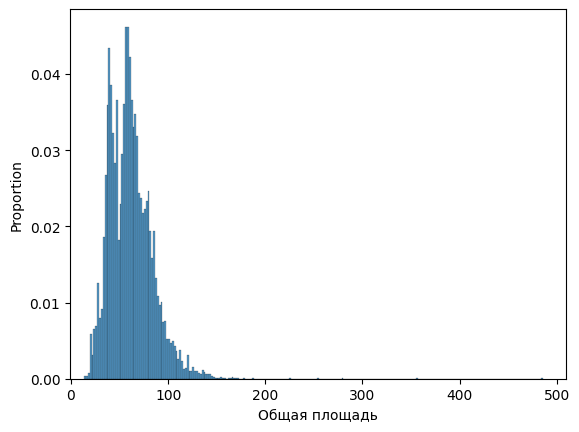

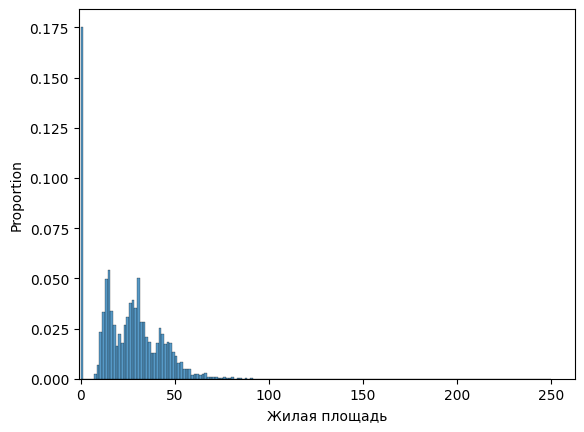

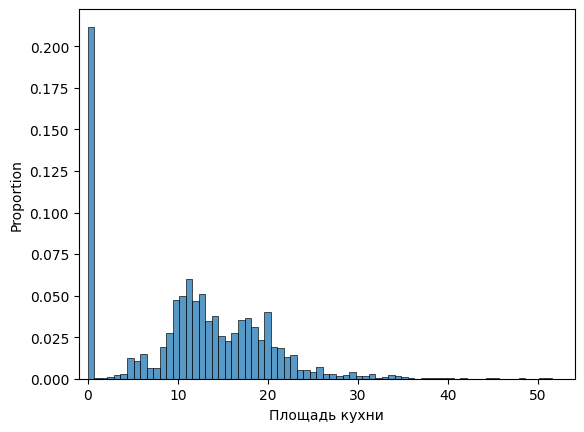

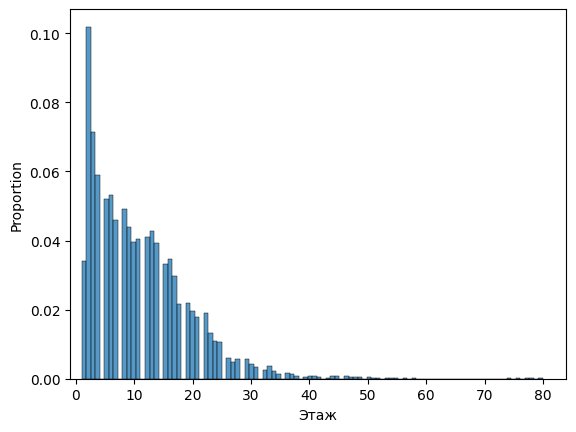

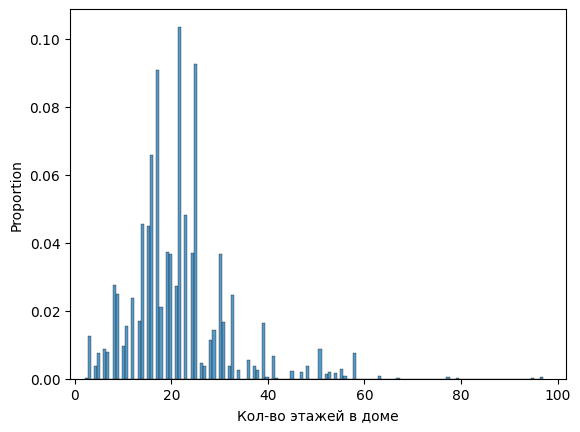

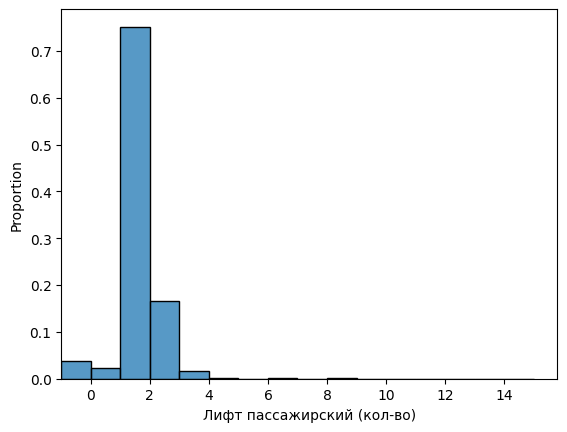

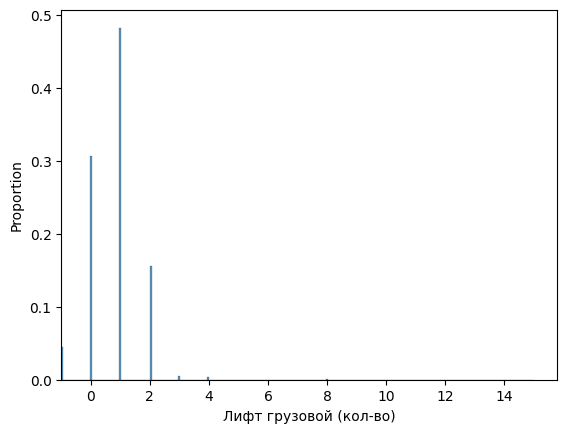

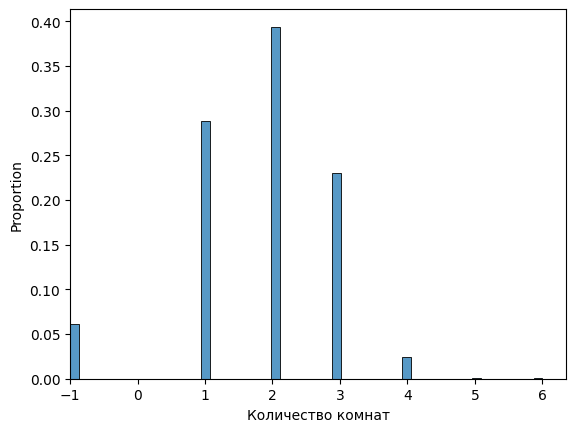

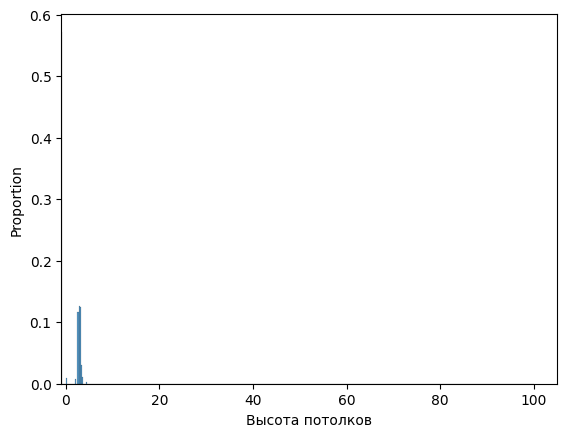

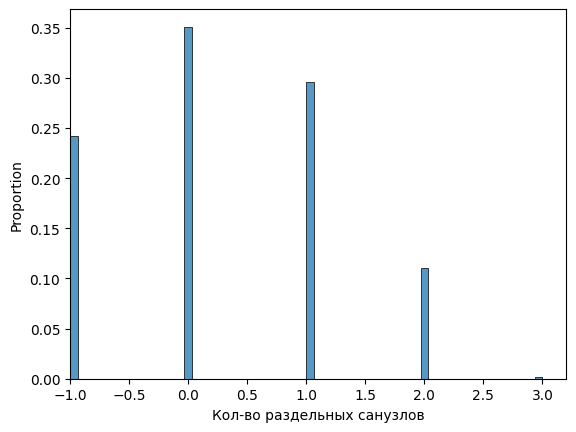

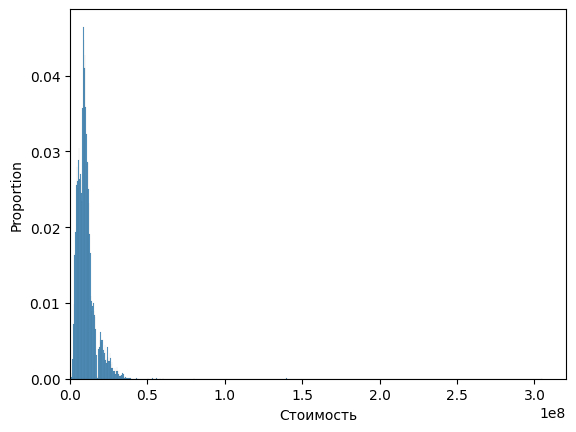

In [ ]:
for col in num_columns:
  ax = sns.histplot(train_df[col].fillna(-1), stat='proportion')
  ax.set_xlim(-1)
  plt.show()

Numeric statistics in the form of table

In [ ]:
train_df[num_columns].describe()

,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Кол-во этажей в доме,Лифт пассажирский (кол-во),Лифт грузовой (кол-во),Количество комнат,Высота потолков,Кол-во раздельных санузлов,Стоимость
count,29044.000000,29044.000000,29044.000000,29044.000000,29044.000000,27948.000000,27753.000000,27252.000000,12420.000000,22018.000000,2.904400e+04
mean,61.179517,24.416416,11.692776,10.975244,21.185374,1.206634,0.877779,1.996441,2.838973,0.686257,1.023393e+07
std,21.809865,16.934981,7.954198,8.442047,9.843159,0.603472,0.783850,0.821366,1.000530,0.719718,6.042127e+06
min,13.500000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.800000e+05
25%,44.367500,13.100000,6.100000,4.000000,15.000000,1.000000,0.000000,1.000000,2.700000,0.000000,6.276445e+06
50%,58.985000,24.700000,12.000000,9.000000,20.000000,1.000000,1.000000,2.000000,2.860000,1.000000,9.219600e+06
75%,73.900000,35.100000,17.300000,16.000000,25.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1.212788e+07
max,486.000000,250.000000,51.500000,80.000000,97.000000,15.000000,15.000000,6.000000,99.999000,3.000000,3.051600e+08


Correlation between dependent variable and numerical features. Apartment prices have a relatively **high correlation** with **Общая площадь** (0.59) and **Количество комнат** (0.36), small with **Жилая площадь** (0.16), **Этаж** (0.17), **Кол-во раздельных санузлов** (0.12) and **Лифт пассажирский кол-во** (0.11).<br>It should be assumed that these will be key features in the top Feature importance.<br>Also, some independent variables correlate with each other, for example, *Лифт пассажирский кол-во* and *Лифт грузовой кол-во* (0.49).

In [ ]:
corr = train_df[num_columns].corr()
corr.style.background_gradient()

,Общая площадь,Жилая площадь,Площадь кухни,Этаж,Кол-во этажей в доме,Лифт пассажирский (кол-во),Лифт грузовой (кол-во),Количество комнат,Высота потолков,Кол-во раздельных санузлов,Стоимость
Общая площадь,1.000000,0.559858,0.192305,-0.017052,0.036623,0.009290,-0.053695,0.815597,-0.012549,0.323782,0.599716
Жилая площадь,0.559858,1.000000,0.352478,-0.092238,-0.151796,-0.085232,0.010534,0.627407,-0.072933,0.283031,0.160153
Площадь кухни,0.192305,0.352478,1.000000,-0.029139,-0.092048,-0.015945,0.162439,-0.021364,-0.096428,0.132234,0.080772
Этаж,-0.017052,-0.092238,-0.029139,1.000000,0.578950,0.209929,0.067319,-0.062688,-0.043339,-0.036160,0.173493
Кол-во этажей в доме,0.036623,-0.151796,-0.092048,0.578950,1.000000,0.267316,0.045759,-0.017886,-0.042574,-0.028261,0.267239
Лифт пассажирский (кол-во),0.009290,-0.085232,-0.015945,0.209929,0.267316,1.000000,0.494415,-0.035771,-0.034551,0.081742,0.110174
Лифт грузовой (кол-во),-0.053695,0.010534,0.162439,0.067319,0.045759,0.494415,1.000000,-0.022823,-0.114666,0.166812,-0.050815
Количество комнат,0.815597,0.627407,-0.021364,-0.062688,-0.017886,-0.035771,-0.022823,1.000000,-0.039094,0.403885,0.365474
Высота потолков,-0.012549,-0.072933,-0.096428,-0.043339,-0.042574,-0.034551,-0.114666,-0.039094,1.000000,-0.105089,0.061892
Кол-во раздельных санузлов,0.323782,0.283031,0.132234,-0.036160,-0.028261,0.081742,0.166812,0.403885,-0.105089,1.000000,0.125159


# Train-val split

For modeling, we will divide our train into train (we train the model) and validation (we evaluate the model, calculate the RMSLE metric), using a random strategy, because no time dependency.

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

RANDOM_SEED = 15

**RMSLE** - less sensitive to outliers than MSE, the metric shows a relative error (because log(y_true) - log(y_pred) = log (y_true/y_pred)) that it "penalizes" for understatement (predicted less than it actually is), while MAE, MSE have the same "penalties" for excess or understatement.

In [ ]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [ ]:
# the size of the val set will be approximately equal to the test dataset
X_tr, X_val, y_tr, y_val = train_test_split(train_df[num_columns[:-1]+cat_columns],
                                            train_df['Стоимость'], test_size=0.28, random_state=RANDOM_SEED)
X_tr.shape[0], X_val.shape[0], test_df.shape[0]

(20911, 8133, 8263)

# Feature engineering

An important point: we fit any encodings, transformations on the train set, and not on the train + shaft, so that there is no data leakage (dataleak) or "peeping into the future"

## Missing values

Let's replace in numeric variables using KNNImputer: look for the 5 nearest neighbors to the current record and take the average value of the column in which the current record has NaN. For categorical variables, we will use -1 as the encoded category.

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_tr[num_columns[:-1]] = imputer.fit_transform(X_tr[num_columns[:-1]])
X_val[num_columns[:-1]] = imputer.transform(X_val[num_columns[:-1]])

## Coding categorical features

Features are converted to ordinal integers, resulting in one column of integers (from 0 to n_categories - 1) for each feature, where missing or new values get -1 as the category.

In [ ]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value',
                     unknown_value=-1, encoded_missing_value=-1)
X_tr[cat_columns] = enc.fit_transform(X_tr[cat_columns])
X_val[cat_columns] = enc.transform(X_val[cat_columns])

## Scaling of numerical features

Some models (especially linear ones) are sensitive to the scale of features, for example, the number of rooms we have is measured in units, when the area of ​​an apartment is in tens. We bring all the features from -1 to 1 using MinMaxScaler.

In [ ]:
scaler = MinMaxScaler()
X_tr[num_columns[:-1]] = scaler.fit_transform(X_tr[num_columns[:-1]])
X_val[num_columns[:-1]] = scaler.transform(X_val[num_columns[:-1]])

# Modeling

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor

## Baseline

As a rule, this is a simple solution that does not require ML. In our case, we will simply predict the average price from the train set.<br>**RMSLE**: 0.569

In [ ]:
y_pred = y_tr.mean()
rmsle(y_val, np.array([y_tr.mean()]*y_val.shape[0]))

0.5691924036930522

## Linear Regression

- Linear regression fits a linear model with coefficients that minimize the residual sum of squares (RSS) between the target variable in the dataset (y_true) and the predictions (y_pred).<br>**RMSLE**: 0.566<br>The most important signs: **Общая площадь**, **Высота потолков**, **Кол-во этажей в доме**<br>The least important features, the weights are close to 0 (possibly due to the fact that the regression works poorly with categorical features): **Расстояние до метро**, **Регион**

In [ ]:
lr = LinearRegression()
lr.fit(X_tr, y_tr)
y_pred = lr.predict(X_val)

# Linear regression does not respect bounds of 0, so it clips so that the predict is always > 0
rmsle(y_val, np.clip(y_pred, a_min=1, a_max=None))

0.5663383074385375

In [ ]:
fi = pd.DataFrame(np.vstack((lr.feature_names_in_, lr.coef_)), index=['feature', 'weight']).transpose()
fi['weight'] = fi['weight'].astype(float)
fi.sort_values('weight', ascending=False)

,feature,weight
0,Общая площадь,9.633300e+07
8,Высота потолков,8.184731e+06
4,Кол-во этажей в доме,6.700659e+06
5,Лифт пассажирский (кол-во),5.301580e+06
2,Площадь кухни,4.019056e+06
3,Этаж,3.922706e+06
19,Есть кухня,1.506336e+06
20,Есть жилая площадь,1.128214e+06
14,Парковка,6.789317e+05
16,Вид из окон,3.411023e+05


Let's try regression without categorical features.<br>**RMSLE**: 0.415.<br>It turns out that categorical features are perceived badly by regression.

In [ ]:
lr = LinearRegression()
lr.fit(X_tr[num_columns[:-1]], y_tr)
y_pred = lr.predict(X_val[num_columns[:-1]])

# Linear regression does not respect bounds of 0, so it clips so that the predict is always > 0
rmsle(y_val, np.clip(y_pred, a_min=1, a_max=None))

0.41544405880488033

In [ ]:
fi = pd.DataFrame(np.vstack((lr.feature_names_in_, lr.coef_)), index=['feature', 'weight']).transpose()
fi['weight'] = fi['weight'].astype(float)
fi.sort_values('weight', ascending=False)

,feature,weight
0,Общая площадь,1.098152e+08
8,Высота потолков,1.268645e+07
4,Кол-во этажей в доме,9.309042e+06
5,Лифт пассажирский (кол-во),9.184732e+06
3,Этаж,3.529628e+06
2,Площадь кухни,9.801332e+04
9,Кол-во раздельных санузлов,-4.184717e+05
6,Лифт грузовой (кол-во),-4.794514e+06
7,Количество комнат,-7.340506e+06
1,Жилая площадь,-1.350812e+07


## Random forest

- The random forest represents a set of several decision trees for different subsamples of the data set (X) and for the final answer (y_pred) uses the average of the answers of all the decision trees built in it. To build trees, the squared error criterion is used, which is equal to the decrease in variance when choosing a feature split.<br>To avoid overfit, let's try to limit the depth of the tree and the number of trees.<br>**RMSLE**: 0.149<br>The most important signs: **Общая площадь**, **Регион**, **Расстояние до метро**, **Жилая площадь**	<br>The least important features (perhaps due to their weak variability): **Мусоропровод**, **Тип**, **Есть жилая площадь**, **Есть кухня**

In [ ]:
models = [
    RandomForestRegressor(max_depth=15, random_state=RANDOM_SEED),
    RandomForestRegressor(n_estimators=50, max_depth=10, random_state=RANDOM_SEED)
]
for i, model in enumerate(models):
    print(model)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    print(f'RMSLE: {round(rmsle(y_val, y_pred), 3)}')
    print('Feature importance:')
    fi = pd.DataFrame(np.vstack((model.feature_names_in_, model.feature_importances_)), index=['feature', 'weight']).transpose()
    fi['weight'] = fi['weight'].astype(float)
    display(fi.sort_values('weight', ascending=False))

RandomForestRegressor(max_depth=15, random_state=15)
RMSLE: 0.149
Feature importance:


,feature,weight
0,Общая площадь,0.378528
18,Регион,0.223730
17,Расстояние до метро,0.083271
1,Жилая площадь,0.081520
4,Кол-во этажей в доме,0.059495
8,Высота потолков,0.055757
10,Опции продажи,0.018355
6,Лифт грузовой (кол-во),0.015496
2,Площадь кухни,0.015288
5,Лифт пассажирский (кол-во),0.014589


RandomForestRegressor(max_depth=10, n_estimators=50, random_state=15)
RMSLE: 0.194
Feature importance:


,feature,weight
0,Общая площадь,0.418075
18,Регион,0.251558
17,Расстояние до метро,0.074008
1,Жилая площадь,0.070357
8,Высота потолков,0.053853
4,Кол-во этажей в доме,0.048511
10,Опции продажи,0.018449
6,Лифт грузовой (кол-во),0.011606
2,Площадь кухни,0.009198
14,Парковка,0.008130


If you remove insignificant features, the metric does not change.

In [ ]:
models = [
    RandomForestRegressor(max_depth=15, random_state=RANDOM_SEED),
    RandomForestRegressor(n_estimators=50, max_depth=10, random_state=RANDOM_SEED)
]
for i, model in enumerate(models):
    print(model)
    model.fit(X_tr.drop(columns=['Мусоропровод', 'Тип', 'Есть жилая площадь', 'Есть кухня']), y_tr)
    y_pred = model.predict(X_val.drop(columns=['Мусоропровод', 'Тип', 'Есть жилая площадь', 'Есть кухня']))
    print(f'RMSLE: {round(rmsle(y_val, y_pred), 3)}')
    print('Feature importance:')
    fi = pd.DataFrame(np.vstack((model.feature_names_in_, model.feature_importances_)), index=['feature', 'weight']).transpose()
    fi['weight'] = fi['weight'].astype(float)
    display(fi.sort_values('weight', ascending=False))

RandomForestRegressor(max_depth=15, random_state=15)
RMSLE: 0.149
Feature importance:


,feature,weight
0,Общая площадь,0.377797
16,Регион,0.224852
1,Жилая площадь,0.084640
15,Расстояние до метро,0.083569
4,Кол-во этажей в доме,0.057323
8,Высота потолков,0.055186
10,Опции продажи,0.017265
3,Этаж,0.016789
2,Площадь кухни,0.016179
6,Лифт грузовой (кол-во),0.013875


RandomForestRegressor(max_depth=10, n_estimators=50, random_state=15)
RMSLE: 0.194
Feature importance:


,feature,weight
0,Общая площадь,0.415742
16,Регион,0.259359
15,Расстояние до метро,0.075352
1,Жилая площадь,0.070848
8,Высота потолков,0.053971
4,Кол-во этажей в доме,0.046848
10,Опции продажи,0.013175
5,Лифт пассажирский (кол-во),0.010989
6,Лифт грузовой (кол-во),0.010643
2,Площадь кухни,0.009505


## LightGBM

Let's try another representative of trees and gradient boosting (the essence is to combine several weak models into one strong one) - LGBMRegressor. Gradient boosting builds the first tree starting from one leaf (something like the initial predict for all samples, for example, the average if the loss function of building MSE). Each subsequent tree is built based on the errors of the previous one (i.e. the goal is to predict the error made by the previous tree). In lightgbm, an implementation of gradient boosting has been created with features that allow you to build a model faster, more efficiently from memory.<br>**RMSLE**: 0.140<br>Feature importance is similar to Random Forest, the metric is slightly better. Features **Мусоропровод**, **Есть жилая площадь**, **Есть кухня** have zero weights, i.e. they were not used at all in the construction of trees.

In [ ]:
lgbm = LGBMRegressor(max_depth=15,
                     importance_type='gain', random_state=RANDOM_SEED
                    ).fit(X_tr, y_tr, categorical_feature=cat_columns)
y_pred = lgbm.predict(X_val)
rmsle(y_val, y_pred)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


0.14020653323318527

In [ ]:
fi = pd.DataFrame(np.vstack((lgbm.feature_name_, lgbm.feature_importances_)), index=['feature', 'weight']).transpose()
fi['weight'] = fi['weight'].astype(float)
fi.sort_values('weight', ascending=False)

,feature,weight
0,Общая_площадь,1.340238e+18
18,Регион,9.517539e+17
17,Расстояние_до_метро,5.840842e+17
4,Кол-во_этажей_в_доме,2.174147e+17
8,Высота_потолков,1.373706e+17
1,Жилая_площадь,6.887173e+16
2,Площадь_кухни,4.392269e+16
6,Лифт_грузовой_(кол-во),4.265370e+16
3,Этаж,3.800835e+16
9,Кол-во_раздельных_санузлов,3.246109e+16


# Test set predictions

To predict the price for the test set, we will train the LightGBM model on the full dataset (the entire train_df).

In [ ]:
X_tr_full = train_df[num_columns[:-1]+cat_columns]
y_tr_full = train_df['Стоимость']
X_tr_full.shape

(29044, 21)

In [ ]:
X_test_full = test_df[num_columns[:-1]+cat_columns]
X_test_full.shape

(8263, 21)

In [ ]:
imputer = KNNImputer(n_neighbors=5)
X_tr_full[num_columns[:-1]] = imputer.fit_transform(X_tr_full[num_columns[:-1]])
X_test_full[num_columns[:-1]] = imputer.transform(X_test_full[num_columns[:-1]])

In [ ]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value',
                     unknown_value=-1, encoded_missing_value=-1)
X_tr_full[cat_columns] = enc.fit_transform(X_tr_full[cat_columns])
X_test_full[cat_columns] = enc.transform(X_test_full[cat_columns])

In [ ]:
scaler = MinMaxScaler()
X_tr_full[num_columns[:-1]] = scaler.fit_transform(X_tr_full[num_columns[:-1]])
X_test_full[num_columns[:-1]] = scaler.transform(X_test_full[num_columns[:-1]])

In [ ]:
lgbm = LGBMRegressor(max_depth=15,
                     importance_type='gain', random_state=RANDOM_SEED
                    ).fit(X_tr_full, y_tr_full, categorical_feature=cat_columns)
y_pred = lgbm.predict(X_test_full)

In [ ]:
fi = pd.DataFrame(np.vstack((lgbm.feature_name_, lgbm.feature_importances_)), index=['feature', 'weight']).transpose()
fi['weight'] = fi['weight'].astype(float)
fi.sort_values('weight', ascending=False)

,feature,weight
0,Общая_площадь,1.909438e+18
18,Регион,1.328079e+18
17,Расстояние_до_метро,8.240434e+17
4,Кол-во_этажей_в_доме,3.094367e+17
8,Высота_потолков,1.454182e+17
1,Жилая_площадь,1.072257e+17
6,Лифт_грузовой_(кол-во),5.605282e+16
3,Этаж,5.138183e+16
7,Количество_комнат,4.520608e+16
14,Парковка,3.655703e+16


In [ ]:
pd.read_csv('drive/MyDrive/hse-gsb-apartment-price-prediction/sample_submission.csv').head()

,ID,Стоимость
0,10422379,100008689
1,192714934,33577602
2,100335930,21142913
3,113635973,66103331
4,125525832,20511625


In [ ]:
submission_df = pd.DataFrame({'ID': test_df['ID'].values, 'Стоимость': y_pred})

In [ ]:
y_pred

array([ 2153934.20998563,  2263817.90850231,  3354892.1915992 , ...,
        7274123.89764277, 11393638.64636301,  6997983.66804739])

In [ ]:
submission_df.astype(int).to_csv('drive/MyDrive/hse-gsb-apartment-price-prediction/submission.csv', index=False)

In [ ]:
pd.read_csv('drive/MyDrive/hse-gsb-apartment-price-prediction/submission.csv').head()

,ID,Стоимость
0,10422379,2153934
1,192714934,2263817
2,100335930,3354892
3,113635973,3438422
4,125525832,13188068


As an option to improve the model: the use of text features that were not used at all, their processing by more advanced models (based on a neural network), pictures